# Modèle CNN

## Imports

In [1]:
import os
import sqlite3
import pandas as pd
import numpy as np
import tensorflow as tf
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
from sklearn.model_selection import KFold, train_test_split
from tqdm import tqdm

2025-07-05 00:09:11.676337: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


## Connexion à la BDD

In [2]:
db_path = os.path.abspath("../db.sqlite3")
print("Connexion à :", db_path)

conn = sqlite3.connect(db_path)
cursor = conn.cursor()
cursor.execute("SELECT name FROM sqlite_master WHERE type='table';")
print("Tables présentes :", cursor.fetchall())

Connexion à : /Users/noormezzi/Desktop/Projet_S6/SolutionDelivery_PRJ/backend/src/db.sqlite3
Tables présentes : [('Image',), ('Location',), ('ClassificationConstraints',), ('sqlite_sequence',)]


## Chargement des données train

In [3]:
query_train = "SELECT Id_Image, File_path, Status FROM Image WHERE Id_Image > 100"
df_train = pd.read_sql_query(query_train, conn)
print(f"Nombre d'images train : {len(df_train)}")

Nombre d'images train : 600


## Chargement des données test

In [4]:
query_test = "SELECT Id_Image, File_path, Status FROM Image WHERE Id_Image <= 100"
df_test = pd.read_sql_query(query_test, conn)
print(f"Nombre d'images test : {len(df_test)}")

Nombre d'images test : 100


## Fonction de préprocessing image

In [5]:
def load_and_preprocess(img_path, target_size=(128,128)):
    img = load_img(img_path, target_size=target_size)
    img_array = img_to_array(img) / 255.0
    return img_array

## Préparation X, y (train)

In [6]:
images_train, labels_train = [], []
for _, row in df_train.iterrows():
    id_image = row['Id_Image']
    img_path = os.path.abspath(f"../../src/media/Data/crops/crop_{id_image}.webp")
    if os.path.exists(img_path):
        images_train.append(load_and_preprocess(img_path))
        labels_train.append(row['Status'])
    else:
        print(f"⚠️ Image manquante : {img_path}")

X = np.array(images_train)
y = np.array(labels_train)

print("✅ Train loaded :", X.shape, y.shape)

✅ Train loaded : (600, 128, 128, 3) (600,)


## Cross-Validation

In [7]:
kf = KFold(n_splits=5, shuffle=True, random_state=42)
cv_acc, cv_loss = [], []

print("\n🔎 Cross-Validation (5 folds)")
for fold, (train_idx, val_idx) in enumerate(kf.split(X), 1):
    print(f"\nFold {fold}")

    X_train, X_val = X[train_idx], X[val_idx]
    y_train, y_val = y[train_idx], y[val_idx]

    model = Sequential([
        Conv2D(32, (3,3), activation='relu', input_shape=(128,128,3)),
        MaxPooling2D(2,2),
        Conv2D(64, (3,3), activation='relu'),
        MaxPooling2D(2,2),
        Flatten(),
        Dense(64, activation='relu'),
        Dropout(0.5),
        Dense(1, activation='sigmoid')
    ])

    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
    model.fit(X_train, y_train, epochs=5, validation_data=(X_val, y_val), verbose=0)

    scores = model.evaluate(X_val, y_val, verbose=0)
    print(f"Loss: {scores[0]:.4f} | Accuracy: {scores[1]*100:.2f}%")
    cv_acc.append(scores[1])
    cv_loss.append(scores[0])

print("\n📊 Cross-validation summary :")
print(f"Mean accuracy: {np.mean(cv_acc)*100:.2f}% (+/- {np.std(cv_acc)*100:.2f}%)")
print(f"Mean loss: {np.mean(cv_loss):.4f} (+/- {np.std(cv_loss):.4f})")


🔎 Cross-Validation (5 folds)

Fold 1


/opt/anaconda3/lib/python3.11/site-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Loss: 0.5124 | Accuracy: 76.67%

Fold 2
Loss: 0.3825 | Accuracy: 85.00%

Fold 3
Loss: 0.5900 | Accuracy: 75.83%

Fold 4
Loss: 0.4729 | Accuracy: 77.50%

Fold 5
Loss: 0.5868 | Accuracy: 70.83%

📊 Cross-validation summary :
Mean accuracy: 77.17% (+/- 4.55%)
Mean loss: 0.5089 (+/- 0.0774)


## Entraînement final

In [8]:
print("\n🏁 Training final model on full train set with validation split")

final_model = Sequential([
    Conv2D(32, (3,3), activation='relu', input_shape=(128,128,3)),
    MaxPooling2D(2,2),
    Conv2D(64, (3,3), activation='relu'),
    MaxPooling2D(2,2),
    Flatten(),
    Dense(64, activation='relu'),
    Dropout(0.5),
    Dense(1, activation='sigmoid')
])

final_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
history_final = final_model.fit(X, y, epochs=10, validation_split=0.2)


🏁 Training final model on full train set with validation split


Epoch 1/10
15/15 ━━━━━━━━━━━━━━━━━━━━ 12s 626ms/step - accuracy: 0.5349 - loss: 1.2530 - val_accuracy: 0.4167 - val_loss: 0.6844
Epoch 2/10
15/15 ━━━━━━━━━━━━━━━━━━━━ 9s 580ms/step - accuracy: 0.5422 - loss: 0.6408 - val_accuracy: 0.7750 - val_loss: 0.5323
Epoch 3/10
15/15 ━━━━━━━━━━━━━━━━━━━━ 12s 818ms/step - accuracy: 0.6996 - loss: 0.5654 - val_accuracy: 0.8083 - val_loss: 0.4831
Epoch 4/10
15/15 ━━━━━━━━━━━━━━━━━━━━ 10s 657ms/step - accuracy: 0.7815 - loss: 0.4824 - val_accuracy: 0.8083 - val_loss: 0.4050
Epoch 5/10
15/15 ━━━━━━━━━━━━━━━━━━━━ 10s 664ms/step - accuracy: 0.8424 - loss: 0.3934 - val_accuracy: 0.7917 - val_loss: 0.4614
Epoch 6/10
15/15 ━━━━━━━━━━━━━━━━━━━━ 10s 642ms/step - accuracy: 0.8421 - loss: 0.3893 - val_accuracy: 0.8333 - val_loss: 0.3895
Epoch 7/10
15/15 ━━━━━━━━━━━━━━━━━━━━ 10s 672ms/step - accuracy: 0.8727 - loss: 0.3318 - val_accuracy: 0.7750 - val_loss: 0.4476
Epoch 8/10
15/15 ━━━━━━━━━━━━━━━━━━━━ 13s 833ms/step - accuracy: 0.9023 - loss: 0.2607 - val_accur

## Sauvegarder le modèle entraîné

In [9]:
final_model.save("trashmap_cn_crop.keras")
print("✅ Modèle final sauvegardé")

✅ Modèle final sauvegardé


## Évaluation sur train

In [10]:
y_pred_train = (final_model.predict(X) > 0.5).astype("int32")
print("\n📈 Evaluation sur train :")
print(classification_report(y, y_pred_train))
print(confusion_matrix(y, y_pred_train))

19/19 ━━━━━━━━━━━━━━━━━━━━ 4s 199ms/step

📈 Evaluation sur train :
              precision    recall  f1-score   support

           0       0.93      0.95      0.94       316
           1       0.95      0.93      0.94       284

    accuracy                           0.94       600
   macro avg       0.94      0.94      0.94       600
weighted avg       0.94      0.94      0.94       600

[[301  15]
 [ 21 263]]


## Courbes du modèle final

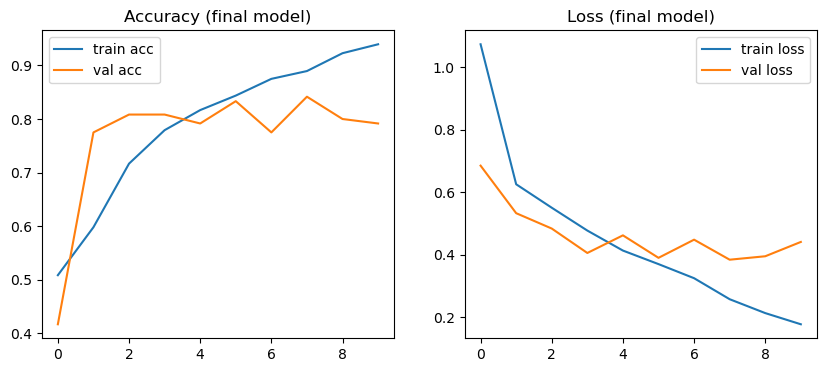

In [11]:
plt.figure(figsize=(10,4))
plt.subplot(1,2,1)
plt.plot(history_final.history['accuracy'], label='train acc')
plt.plot(history_final.history['val_accuracy'], label='val acc')
plt.legend()
plt.title("Accuracy (final model)")

plt.subplot(1,2,2)
plt.plot(history_final.history['loss'], label='train loss')
plt.plot(history_final.history['val_loss'], label='val loss')
plt.legend()
plt.title("Loss (final model)")
plt.show()

## Évaluation sur test

In [12]:
images_test, labels_test = [], []
for _, row in df_test.iterrows():
    id_image = row['Id_Image']
    img_path = os.path.abspath(f"../../src/media/Data/crops/crop_{id_image}.webp")
    if os.path.exists(img_path):
        images_test.append(load_and_preprocess(img_path))
        labels_test.append(row['Status'])
    else:
        print(f"⚠️ Image manquante : {img_path}")

X_test = np.array(images_test)
y_test = np.array(labels_test)

print("✅ Test set loaded :", X_test.shape)

y_pred_test = (final_model.predict(X_test) > 0.5).astype("int32")
print("\n📈 Evaluation sur test :")
print(classification_report(y_test, y_pred_test))
print(confusion_matrix(y_test, y_pred_test))

✅ Test set loaded : (100, 128, 128, 3)
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 244ms/step

📈 Evaluation sur test :
              precision    recall  f1-score   support

           0       0.80      0.73      0.76        51
           1       0.74      0.82      0.78        49

    accuracy                           0.77       100
   macro avg       0.77      0.77      0.77       100
weighted avg       0.77      0.77      0.77       100

[[37 14]
 [ 9 40]]
